Load modules to be used in the execution of the problem.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import math
import HW03_utils as ut
import numpy as np
from matplotlib import pyplot as plt

In [4]:
def normalize_images(image_vectors):
# Function to normalize pixel contrast of images

        magnitudes = np.linalg.norm(image_vectors,axis=1)
        normalized_ims = image_vectors/magnitudes[:,None]
        return normalized_ims

In [5]:
def get_class_bounds(classid,labels):
# Function to extract index bounds of the specified class from the dataset

    for i in range(len(labels)):
        if labels[i] == classid:
            startindex = i
            break
    stopindex = len(labels)
    for i in range(i,len(labels)):
        if labels[i] != classid:
            stopindex = i
            break
    
    return startindex,stopindex


In [6]:
def get_class_from_data(classid,data,labels):
# Find the start (inclusive) and end (exclusive) of a class within the data, then separate and return the class

    startindex,stopindex = get_class_bounds(classid,labels)
    
    # Separate the specified class
    class_data = data[startindex:stopindex]
            
    return class_data


In [7]:
def mean_of_class(classid,data,labels):
# Calculate the mean value when the class is fit to a normal distribution
    
    class_data = get_class_from_data(classid,data,labels)   
    # Calculate the mean of the class data
    class_mu = np.mean(class_data,axis=0)
    
    return class_mu


In [8]:
def cov_of_class(classid,data,labels):
# Calcualte the covariance matrix when the class is fit to a normal distribution

    class_data = get_class_from_data(classid,data,labels)
    # Calculate the covariance matrix from the class data
    class_Sigma = np.cov(class_data,rowvar=False)
    
    return class_Sigma


In [9]:
def calc_SigmaHat(data,labels,muCs):
# Function to calculate the average covariance matrix for the distribution (1 covariance matrix for LDA)

    SigmaHat = np.zeros((len(data[0]),len(data[0])))
    for i in range(len(data)):
        Xi_minus_muC = data[i] - muCs[labels[i]]
        SigmaHat += np.outer(Xi_minus_muC,Xi_minus_muC)
    
    SigmaHat = SigmaHat/len(labels)
    
    return SigmaHat


In [10]:
def zero_rows(sym_matrix):
# Take a symmetric matrix and find rows/columns that are empty

    zero_rows = []
    for i in range(len(sym_matrix)):
        if not np.any(sym_matrix[i]):
            zero_rows.append(i)
        
    return zero_rows

In [11]:
def makeInvertible(sym_matrix):
# Take a symmetric non-invertible matrix, and eliminate rows/columns to make it invertible
    
    ZR = zero_rows(sym_matrix)
    newlen = len(sym_matrix)-len(ZR)
    invmatrix = np.empty((newlen,newlen))
    I = 0
    for i in range(len(sym_matrix)):
        if i in ZR:
            continue
        J = 0
        for j in range(len(sym_matrix)):
            if j in ZR:
                continue
            invmatrix[I,J] = sym_matrix[i,j]
            J += 1
        I += 1
            
    return invmatrix


In [12]:
def removeZeroVariance(cov_matrix,valdata):
# Remove variables with zero variance in the covariance matrix from the validation data set
#      -valdata is a nxd array with n rows of samples and d-variables per sample
#      -Cov_matrix is a dxd matrix giving the covariances of the d-variables

    ZR = zero_rows(cov_matrix)
    # Create a new array with validation data corresponding to variables in training set with non-zero variance
    NZV_data = np.empty((len(valdata),len(valdata[0])-len(ZR)))
    columnI = 0
    for columni in range(len(valdata[0])):
        if columni in ZR:
            continue
        NZV_data[:,columnI] = valdata[:,columni]
        columnI += 1
    
    return NZV_data


In [13]:
def MuAndPi(train_labels,muCs,cov_matrix,ZR):
    mu_i = []
    pi_i = []
    for i in range(10):
        # Calculate the mean (without zero variance variables)
        mu_i.append(np.zeros(np.shape(cov_matrix)[0]))
        J = 0
        for j in range(np.shape(muCs[i])[0]):
            if j in ZR:
                continue
            mu_i[i][J] = muCs[i][j]
            J += 1
        
        # Calculate the prior probability
        startindex,stopindex = get_class_bounds(i,train_labels)
        nPoints = stopindex-startindex
        pi_i.append(nPoints/np.shape(train_labels)[0])
        
    return mu_i,pi_i


In [14]:
def LDF_solve(X,mu_C,Sigma,pi_C=0.1):
# Function to solve the linear discriminant function for class C (will compute LDF for 1 variable but for all data points)
    
    LDFs_C = np.zeros(len(X))
    muCinvSigma = np.dot(mu_C,np.linalg.pinv(Sigma))
    muCinvSigmamuC = np.dot(muCinvSigma,mu_C)
    logpiC = math.log(pi_C)
    for i in range(len(X)):
        x = X[i]
        LDFs_C[i] = np.dot(muCinvSigma,x) - 0.5*muCinvSigmamuC + logpiC
    
    return LDFs_C
    

In [15]:
def maximize_LDFs(valdata,mu_i,cov_matrix,pi_i):
    lin_disc_fns = np.empty((len(valdata),10))
    for i in range(10):
        mu_C = mu_i[i]
        pi_C = pi_i[i]
        lin_disc_fns[:,i] = LDF_solve(valdata,mu_C,cov_matrix,pi_C)
    max_LDF_indices = np.empty(len(valdata))
    for i in range(len(valdata)):
        max_LDF_indices[i] = np.argmax(lin_disc_fns[i])
    
    return max_LDF_indices

In [16]:
CS_DIR = r"/Users/mitch/Documents/Cal/2 - 2017 Spring/COMPSCI 289A - Intro to Machine Learning/"

In [17]:
# Load MNIST data
data_array = ut.loaddata("hw3_mnist_dist/hw3_mnist_dist/train.mat",CS_DIR+r"HW03/Data","trainX")

In [18]:
# Shuffle data and set aside validation set
np.random.shuffle(data_array)

trainarray = data_array[:-10000]
valarray = data_array[-10000:]

In [19]:
def main(traindata,trainlabels,valdata,vallabels):
# Main block of code
    
    # Create a list of the means for each class
    muCs = np.empty((10,len(traindata[0])))
    for i in range(10):
        muCs[i] = mean_of_class(i,traindata,trainlabels)

    SigmaHat = calc_SigmaHat(traindata,trainlabels,muCs)

    newcov = makeInvertible(SigmaHat)
    newvaldata = removeZeroVariance(SigmaHat,valdata)

    ZR = zero_rows(SigmaHat)

    mu_i,pi_i = MuAndPi(trainlabels,muCs,newcov,ZR)

    digitPicks = maximize_LDFs(newvaldata,mu_i,newcov,pi_i)
    count, total = 0,0
    for i in range(len(digitPicks)):
        if digitPicks[i] == vallabels[i]:
            count += 1
        total += 1
        
    # VERBOSE COMMANDS FOR WATCHING PROGRESS [OPTIONAL]
    #    if total%200 == 0:
    #        print(total,'points evaluated; current score =',count/total)
    
    score = count/total

    return score
    

In [20]:
# Organize array by digit
trainarray_byclass = trainarray[trainarray[:,-1].argsort()]
valarray_byclass = valarray[valarray[:,-1].argsort()]

train_data = trainarray_byclass[:,:-1]
train_labels = trainarray_byclass[:,-1]

val_data = valarray_byclass[:,:-1]
val_labels = valarray_byclass[:,-1]

normalized_traindata = normalize_images(train_data)
normalized_valdata = normalize_images(val_data)

In [25]:
samples = [100,200,500,1000,2000,5000,10000,30000,50000]

In [21]:
# Train on subsets of full training data set
scores = []
for number in samples:
    trainarraysubset = trainarray[:number]
    
    # Organize array by digit
    trainarray_byclass = trainarraysubset[trainarraysubset[:,-1].argsort()]
    valarray_byclass = valarray[valarray[:,-1].argsort()]
    
    # Separate data and labels
    train_data = trainarray_byclass[:,:-1]
    train_labels = trainarray_byclass[:,-1]
    val_data = valarray_byclass[:,:-1]
    val_labels = valarray_byclass[:,-1]
    
    # Normalize training and validation data
    normalized_train_data = normalize_images(train_data)
    normalized_val_data = normalize_images(val_data)
    
    print(number,"training samples: ")
    score = main(normalized_train_data,train_labels,normalized_val_data,val_labels)
    scores.append(score)
    print(score)
    

100 training samples: 
0.7026
200 training samples: 
0.7145
500 training samples: 
0.3655
1000 training samples: 
0.675
2000 training samples: 
0.7914
5000 training samples: 
0.8403
10000 training samples: 
0.8615
30000 training samples: 
0.8701
50000 training samples: 
0.8742


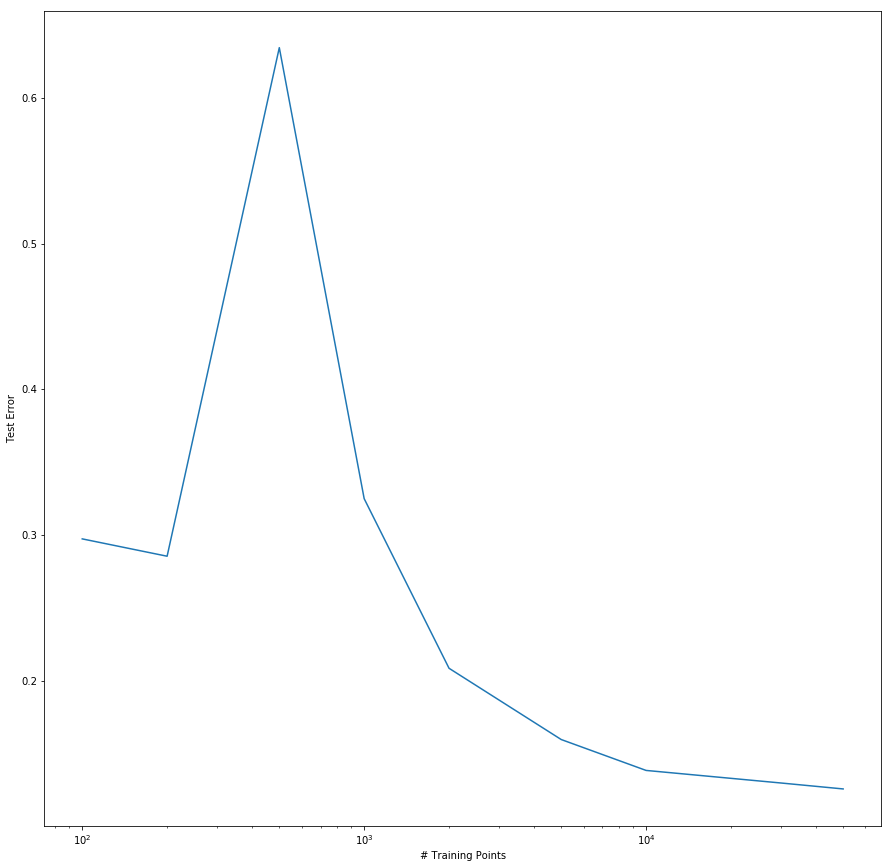

In [30]:
errors = np.ones(len(scores))-np.array(scores)

fig = plt.figure(figsize=(15,15))
plt.semilogx(samples,error)
plt.xlabel("# Training Points")
plt.ylabel("Test Error")
plt.savefig("LDA_errors.jpg")
plt.show()

In [31]:
print(errors)

[ 0.2974  0.2855  0.6345  0.325   0.2086  0.1597  0.1385  0.1299  0.1258]
